# Portfolio 4, Methods 3 2021
### Author: Sigurd Fyhn Sørensen
### 30-11-21

In [35]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt

# Exercises and objectives



1) Use principal component analysis to improve the classification of subjective experience  
2) Use logistic regression with cross-validation to find the optimal number of principal components  




REMEMBER: In your report, make sure to include code that can reproduce the answers requested in the exercises below (__MAKE A KNITTED VERSION__)  
REMEMBER: This is Assignment 4 and will be part of your final portfolio   



# EXERCISE 1 - Use principal component analysis to improve the classification of subjective experience  

We will use the same files as we did in Assignment 3
The files `megmag_data.npy` and `pas_vector.npy` can be downloaded here (http://laumollerandersen.org/data_methods_3/megmag_data.npy) and here (http://laumollerandersen.org/data_methods_3/pas_vector.npy)  
The function `equalize_targets` is supplied - this time, we will only work with an equalized data set. One motivation for this is that we have a well-defined chance level that we can compare against. Furthermore, we will look at a single time point to decrease the dimensionality of the problem  



1) Create a covariance matrix, find the eigenvectors and the eigenvalues


    i. Load `megmag_data.npy` and call it `data` using `np.load`. You can use `join`, which can be imported from `os.path`, to create paths from different string segments 


In [36]:
"""import requests
import io

response = requests.get('http://laumollerandersen.org/data_methods_3/megmag_data.npy')
response.raise_for_status()
data = np.load(io.BytesIO(response.content))


response = requests.get('http://laumollerandersen.org/data_methods_3/pas_vector.npy')
response.raise_for_status()
y = np.load(io.BytesIO(response.content))"""

"import requests\nimport io\n\nresponse = requests.get('http://laumollerandersen.org/data_methods_3/megmag_data.npy')\nresponse.raise_for_status()\ndata = np.load(io.BytesIO(response.content))\n\n\nresponse = requests.get('http://laumollerandersen.org/data_methods_3/pas_vector.npy')\nresponse.raise_for_status()\ny = np.load(io.BytesIO(response.content))"

In [37]:
data = np.load("/Users/sigurd/Downloads/megmag_data.npy")
y = np.load("/Users/sigurd/Downloads/pas_vector.npy")

ii. Equalize the number of targets in `y` and `data` using `equalize_targets`  


In [38]:
def equalize_targets(data, y):
    np.random.seed(7)
    targets = np.unique(y)
    counts = list()
    indices = list()
    for target in targets:
        counts.append(np.sum(y == target))
        indices.append(np.where(y == target)[0])
    min_count = np.min(counts)
    first_choice = np.random.choice(indices[0], size=min_count, replace=False)
    second_choice = np.random.choice(indices[1], size=min_count, replace=False)
    third_choice = np.random.choice(indices[2], size=min_count, replace=False)
    fourth_choice = np.random.choice(indices[3], size=min_count, replace=False)
    
    new_indices = np.concatenate((first_choice, second_choice,
                                 third_choice, fourth_choice))
    new_y = y[new_indices]
    new_data = data[new_indices, :, :]
    
    return new_data, new_y

data_equa, y_equa = equalize_targets(data, y)

iii. Construct `times=np.arange(-200, 804, 4)` and find the index corresponding to 248 ms - then reduce the dimensionality of `data` from three to two dimensions by only choosing the time index corresponding to 248 ms (248 ms was where we found the maximal average response in Assignment 3) 


In [39]:
times = np.arange(-200, 804, 4)

data_equa_reduc = data_equa[:,:,np.argwhere(times == 248).item()]
data_equa_reduc.shape

(396, 102)

iv. Scale the data using `StandardScaler`  


In [40]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
data_equa_reduc_std = sc.fit_transform(data_equa_reduc)


v. Calculate the sample covariance matrix for the sensors (you can use `np.cov`) and plot it (either using `plt.imshow` or `sns.heatmap` (`import seaborn as sns`))  


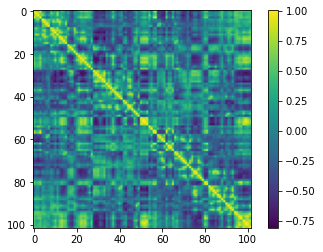

In [41]:
cov = np.cov(data_equa_reduc_std.T)
plt.imshow(cov)
plt.colorbar()

vi. What does the off-diagonal activation imply about the independence of the signals measured by the 102 sensors?  


The covariance values around the diagonal (sensors with close index numbers) seem to have a high covariance (light green). If sensors were placed in a numerical order those with close index number would be close to one another. Following the assumption of sensor location the covariance matrix makes a lot of sense. Sensors located close to each other record similar activity and therefore share covariance.   

vii. Run `np.linalg.matrix_rank` on the covariance matrix - what integer value do you get? (we'll use this later)  


In [42]:
e = np.linalg.matrix_rank(cov)
e

97

viii. Find the eigenvalues and eigenvectors of the covariance matrix using `np.linalg.eig` - note that some of the numbers returned are complex numbers, consisting of a real and an imaginary part (they have a _j_ next to them). We are going to ignore this by only looking at the real parts of the eigenvectors and -values. Use `np.real` to retrieve only the real parts  


In [43]:
eigen_value, eigen_vec  = np.linalg.eig(cov)
#remove complex numbers
real_eigen_val = np.real(eigen_value)
real_eigen_vec = np.real(eigen_vec)

2) Create the weighting matrix $W$ and the projected data, $Z$


    i. We need to sort the eigenvectors and eigenvalues according to the absolute values of the eigenvalues (use `np.abs` on the eigenvalues).  


In [44]:
real_eigen_val = np.abs(real_eigen_val)


ii. Then, we will find the correct ordering of the indices and create an array, e.g. `sorted_indices` that contains these indices. We want to sort the values from highest to lowest. For that, use `np.argsort`, which will find the indices that correspond to sorting the values from lowest to highest. Subsequently, use `np.flip`, which will reverse the order of the indices.   


In [45]:
indx = np.argsort(real_eigen_val)
indx = np.flip(indx)

iii. Finally, create arrays of sorted eigenvalues and eigenvectors using the `sorted_indices` array just created. For the eigenvalues, it should like this `eigenvalues = eigenvalues[sorted_indices]` and for the eigenvectors: `eigenvectors = eigenvectors[:, sorted_indices]`


In [46]:
real_eigen_val = real_eigen_val[indx]

iv. Plot the log, `np.log`, of the eigenvalues, `plt.plot(np.log(eigenvalues), 'o')` - are there some values that stand out from the rest? In fact, 5 (noise) dimensions have already been projected out of the data - how does that relate to the matrix rank (Exercise 1.1.vii)  


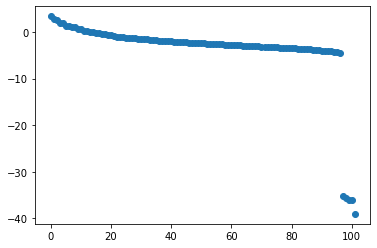

array([[101]])

In [47]:
plt.plot(np.log(real_eigen_val), 'o')
plt.show()


np.argwhere(np.log(real_eigen_val) == np.log(real_eigen_val).min())

As shown with both e = np.linalg.matrix_rank(cov) and np.argwhere(np.log(real_eigen_val) == np.log(real_eigen_val).min()) == 101. So this is the index number for the lowest value on the log scale and original scale. The last five eigenvalues are now so small they barely explain any variance. The amount of variance they acutaly explain is already explained by the other eigenvectors. We have a matrix rank of 97, ie. we can have 97 unique eigenvectors with their own explaining any more than that will only explain that which is already explained. We've 102 features and 102-97 = 5, ie. we must have 5 vectors doing no new explaining and therefore their low eigenvalue. 

np.log(1e-15)

    v. Create the weighting matrix, `W` (it is the sorted eigenvectors)  


In [48]:
sort_real_eigen_vec = real_eigen_vec[:,indx]

vi. Create the projected data, `Z`, $Z = XW$ - (you can check you did everything right by checking whether the $X$ you get from $X = ZW^T$ is equal to your original $X$, `np.isclose` may be of help)


In [49]:


X_new = data_equa_reduc_std @ sort_real_eigen_vec
X_old = X_new @ sort_real_eigen_vec.T

np.isclose( data_equa_reduc_std, X_old )



array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

vii. Create a new covariance matrix of the principal components (n=102) - plot it! What has happened off-diagonal and why?


[[-1.36356497e+00  7.73472913e-01 -3.77969254e+00 ...  1.02613193e-09
   1.02613207e-09  1.32908514e-09]
 [ 6.48447356e+00  2.80100060e+00  3.13556004e+00 ...  3.13545317e-09
   3.13545303e-09  3.78206968e-09]
 [ 5.14241649e+00  4.77568372e+00  3.02071757e+00 ... -5.73524582e-10
  -5.73525248e-10 -6.60052108e-10]
 ...
 [ 4.80074660e+00  4.18979694e+00  6.59773262e-01 ... -6.00444911e-10
  -6.00444911e-10 -7.59573807e-10]
 [ 2.00350207e+00 -1.41860866e-02 -3.46460258e+00 ... -8.26901780e-10
  -8.26901780e-10 -1.13380059e-09]
 [ 2.20807406e+00 -6.17523595e+00  7.68468211e+00 ...  3.57630243e-11
   3.57634684e-11  1.11151721e-10]]


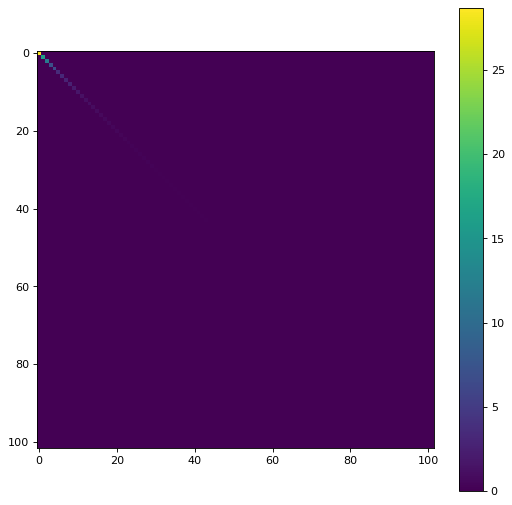

In [50]:
from matplotlib.pyplot import figure

figure(figsize=(8, 8), dpi=80)

cov2 = np.cov(X_new.T)
plt.imshow(cov2)
plt.colorbar()

print(X_new)




Now we got no covariance except on the diagonal. Which makes sense since the point of the PCA is to remove covariance between features by making them orthogonal. Because our eigenvectors are sorted from high -> low eigenvalues our eigenvectors with most variance will be indexed first. Around index 20 the rest of the covariance/variance of the feature is so low that it doesn't show on the plot. 


# EXERCISE 2 - Use logistic regression with cross-validation to find the optimal number of principal components  


1) We are going to run logistic regression with in-sample validation 


In [51]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression

i. First, run standard logistic regression (no regularization) based on $Z_{d \times k}$ and `y` (the target vector). Fit (`.fit`) 102 models based on: $k = [1, 2, ..., 101, 102]$ and $d = 102$. For each fit get the classification accuracy, (`.score`), when applied to $Z_{d \times k}$ and $y$. This is an in-sample validation. Use the solver `newton-cg` if the default solver doesn't converge


In [52]:
def n_pca():
    accuracy = []
    lr = LogisticRegression(solver = "newton-cg", random_state= 10)
    for i in range(102):
        i = i + 1
        lr.fit(X_new[:,range(i)], y_equa)
        score_lul = lr.score(X_new[:,range(i)], y_equa)
        print(score_lul)
        accuracy.append(score_lul)
    return(accuracy)
accuracy_n_feat = n_pca()


0.27525252525252525
0.3207070707070707
0.3333333333333333
0.351010101010101
0.3409090909090909
0.36363636363636365
0.3712121212121212
0.3661616161616162
0.3787878787878788
0.3787878787878788
0.3813131313131313
0.39141414141414144
0.3838383838383838
0.4116161616161616
0.42424242424242425
0.4393939393939394
0.4292929292929293
0.4393939393939394
0.43686868686868685
0.4444444444444444
0.45707070707070707
0.46464646464646464
0.4494949494949495
0.4621212121212121
0.46464646464646464
0.4772727272727273
0.48484848484848486
0.4797979797979798
0.4823232323232323
0.4898989898989899
0.494949494949495
0.5151515151515151
0.5151515151515151
0.5227272727272727
0.51010101010101
0.5176767676767676
0.5176767676767676
0.5227272727272727
0.5303030303030303
0.5378787878787878
0.5328282828282829
0.5303030303030303
0.5378787878787878
0.5176767676767676
0.5227272727272727
0.5277777777777778
0.5176767676767676
0.5151515151515151
0.5202020202020202
0.5252525252525253
0.5353535353535354
0.5378787878787878
0.53787

In [53]:
print("number of pca_values:" , len(accuracy_n_feat))

number of pca_values: 102


ii. Make a plot with the number of principal components on the _x_-axis and classification accuracy on the _y_-axis - what is the general trend and why is this so?


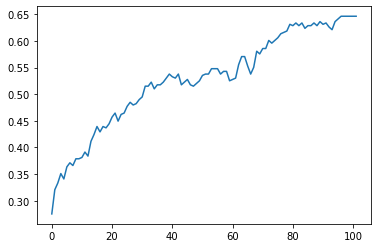

In [54]:
plt.plot(accuracy_n_feat)
plt.show()

iii. In terms of classification accuracy, what is the effect of adding the five last components? Why do you think this is so?


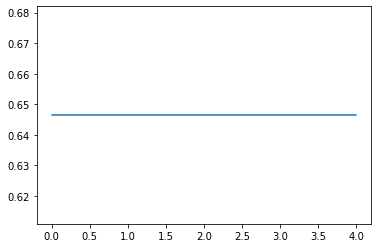

In [55]:
plt.plot(accuracy_n_feat[-6:-1])
plt.show()

Our new PCA feature matrix is sorted based by descending eigenvalues.  
As we can see adding the last features with the comparatively lowest eigenvalues does not add anything to the model. This is due to our matrix rank = 97 as argued earlier any additional vectors beyond will do no new explaining. 

2) Now, we are going to use cross-validation - we are using `cross_val_score` and `StratifiedKFold` from `sklearn.model_selection`


In [56]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

i. Define the variable: `cv = StratifiedKFold()` and run `cross_val_score` (remember to set the `cv` argument to your created `cv` variable). Use the same `estimator` in `cross_val_score` as in Exercise 2.1.i. Find the mean score over the 5 folds (the default of `StratifiedKFold`) for each $k$, $k = [1, 2, ..., 101, 102]$  


In [57]:
def n_pca_cv(X, y):
    cv = StratifiedKFold()
    accuracy = []
    lr = LogisticRegression(solver = "newton-cg", random_state= 10)
    for i in range(102):
        i = i + 1 
        lr.fit(X[:,range(i)], y)
        score_lul = cross_val_score(lr ,X[:,range(i)], y, cv = cv)
        print(np.mean(score_lul))
        accuracy.append(np.mean(score_lul))
    return(accuracy)


accuracy_n_feat_cv = n_pca_cv(X = X_new, y = y_equa)



0.23474683544303798
0.2952215189873418
0.3003481012658228
0.3229746835443038
0.2901898734177215
0.30550632911392406
0.30797468354430374
0.3105696202531646
0.323132911392405
0.32819620253164555
0.3231645569620253
0.3307911392405064
0.3333544303797469
0.36360759493670886
0.3534493670886076
0.36629746835443033
0.3486392405063291
0.3334810126582279
0.3435759493670886
0.3536708860759494
0.3587341772151899
0.34854430379746837
0.33591772151898736
0.35860759493670885
0.36123417721518986
0.3561708860759494
0.3536075949367089
0.3459810126582279
0.34348101265822784
0.35610759493670885
0.35607594936708864
0.3459493670886076
0.3510126582278481
0.3611708860759494
0.34854430379746837
0.34098101265822783
0.34351265822784816
0.33591772151898736
0.3207278481012658
0.3232594936708861
0.3030379746835443
0.30047468354430384
0.29037974683544304
0.298006329113924
0.28784810126582283
0.28531645569620256
0.29037974683544304
0.28531645569620256
0.2827848101265823
0.28528481012658224
0.27772151898734176
0.297974

ii. Make a plot with the number of principal components on the _x_-axis and classification accuracy on the _y_-axis - how is this plot different from the one in Exercise 2.1.ii?


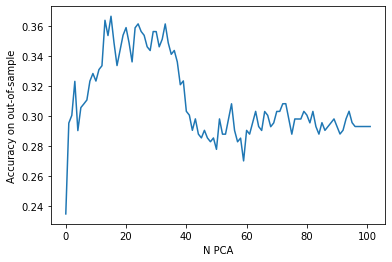

In [58]:
plt.plot(accuracy_n_feat_cv)
plt.xlabel("N PCA")
plt.ylabel("Accuracy on out-of-sample")
plt.show()


In exercise 2.1.ii we saw that for each additional feature added we got a better and better accuracy rating. Whether this fit can generalize beyond in-sample prediction is tested now. As illustrated by our plot adding additional PCA features only improves our models generalizability up until 40 added features with the best accuracy around 15 features. Beyond 40 features we're overfitting the training data too much.   

iii. What is the number of principal components, $k_{max\_accuracy}$, that results in the greatest classification accuracy when cross-validated?  


In [59]:
print("indx for max value/ number of PCA features:",np.argmax(accuracy_n_feat_cv), "\n value:", np.max(accuracy_n_feat_cv)*100, "%")


indx for max value/ number of PCA features: 15 
 value: 36.629746835443036 %


iv. How many percentage points is the classification accuracy increased with relative to the to the full-dimensional, $d$, dataset 


In [60]:
data_equa_2d = np.reshape(data_equa, newshape = (data_equa.shape[0], -1))
cv = StratifiedKFold()
lr2 = LogisticRegression(random_state = 10, solver= "newton-cg")
data_equa_2d_std = sc.fit_transform(data_equa_2d)
lr2.fit(data_equa_2d_std, y_equa)
acc_all_data = np.mean(cross_val_score(lr2, data_equa_2d_std, y_equa, cv = cv))
print("accuracy score all data:", acc_all_data , "\n diff from PCA:",  np.max(accuracy_n_feat_cv) - acc_all_data )



accuracy score all data: 0.27528481012658224 
 diff from PCA: 0.0910126582278481


Cross validated Logistic regression conducted on the entire data results in an accuracy score of 24.24%. And CV logistic regression on the PCA data is 9% points better compared to the model on the entire data.   

v. How do the analyses in Exercises 2.1 and 2.2 differ from one another? Make sure to comment on the differences in optimization criteria.  


Exercise 2.1 is validated on the training data, this is prone to overfitting, and you can therefore not be sure that your result can generalize. 
Exercise 2.2 is validated on out-of-sample data. This makes sure that our model can give good accuracies on unseen data. (Which is what we want in ML).
Our "real" optimization criteria has not changed. Logistic regression still only tries to find the best line based on the training data. If you talk of "optimization" in terms of model reliability. The differences found in the explanation of Exercise 2.1 and Exercise 2.2 is used to underline this. 

3) We now make the assumption that $k_{max\_accuracy}$ is representative for each time sample (we only tested for 248 ms). We will use the PCA implementation from _scikit-learn_, i.e. import `PCA` from `sklearn.decomposition`.


i. For __each__ of the 251 time samples, use the same estimator and cross-validation as in Exercises 2.1.i and 2.2.i. Run two analyses - one where you reduce the dimensionality to $k_{max\_accuracy}$ dimensions using `PCA` and one where you use the full data. Remember to scale the data (for now, ignore if you get some convergence warnings - you can try to increase the number of iterations, but this is not obligatory)  


In [61]:
from sklearn.decomposition import PCA

def n_feat_lr():
    score_pca = []
    score_big = []
    cv = StratifiedKFold()
    lr = LogisticRegression(solver = "newton-cg", random_state= 10)
    lr2 = LogisticRegression(solver = "newton-cg", random_state= 10)
    for i in range(251):
        #transform X
        sc = StandardScaler()
        X = sc.fit_transform(data_equa[:,:,i])
        pc = PCA(n_components = np.argmax(accuracy_n_feat_cv))
        X_pca = pc.fit_transform(X)
        #fit data
        lr.fit(X, y_equa)
        lr2.fit(X_pca, y_equa)

        score_big.append(np.mean(cross_val_score(lr, X, y_equa, cv = cv)))
        score_pca.append(np.mean(cross_val_score(lr2, X_pca, y_equa, cv = cv)))


    return score_big, score_pca
    

score_all, score_pca = n_feat_lr()
    


ii. Plot the classification accuracies for each time sample for the analysis with PCA and for the one without in the same plot. Have time (ms) on the _x_-axis and classification accuracy on the _y_-axis 


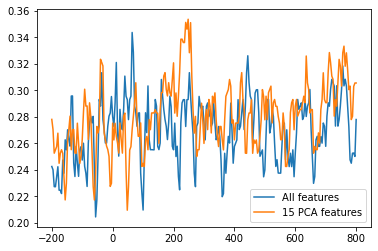

In [62]:
plt.plot(times ,score_all, label = "All features")
plt.plot(times ,score_pca, label = "15 PCA features")
plt.legend()
plt.show()

iii. Describe the differences between the two analyses - focus on the time interval between 0 ms and 400 ms - describe in your own words why the logistic regression performs better on the PCA-reduced dataset around the peak magnetic activity  



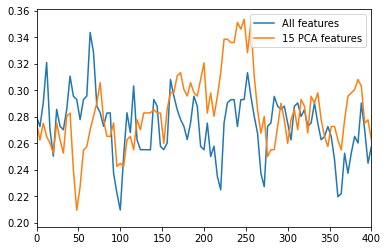

In [63]:
plt.plot(times ,score_all, label = "All features")
plt.plot(times ,score_pca, label = "15 PCA features")
plt.xlim(0,400)
plt.legend()
plt.show()

The PCA model performs better around peak magnetic activity because of the amount of data. Because we define peak magnetic activity as the max value of averaged activity across all samples we're also liable to see the most activity when all samples show high activation. When all samples are activated at the same time we're bound to have a lot more covariance between our features compared to when only few showed activity. So around 200-250ms we see an activation across all samples which result in large covariance which PCA manages to remove through eigenvector and eigenvalue calculation. This is why PCA performs better around the 200-250 ms mark compared to the non-pca all feature model with alot of covariance at those time points. 